In [30]:
import cv2
from moviepy.editor import VideoFileClip
import time
from IPython.display import Image, display, Audio, Markdown
import base64
import os
from openai import OpenAI 

## Set the API key and model name
MODEL="gpt-4o"
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Video

## Extract frames from video

In [47]:
def process_video(video_path, seconds_per_frame=2, save_images=False):
    base64Frames = []

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)

    print(f"Total frames: {total_frames}")
    print(f"FPS: {fps}")
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(f"Resolution: {width}x{height}")

    

    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        frame = cv2.resize(frame, (width // 4, height // 4))
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    if save_images:
        for i, frame in enumerate(base64Frames):
            os.makedirs("extracted_frames", exist_ok=True)
            with open(f"extracted_frames/frame_{i}.jpg", "wb") as f:
                f.write(base64.b64decode(frame))

    print(f"Extracted {len(base64Frames)} frames")
    return base64Frames

VIDEO_PATH = "/Users/sarathmenon/Desktop/mario_vid.mov"
base64Frames = process_video(VIDEO_PATH, seconds_per_frame=1, save_images=True)

Total frames: 943
FPS: 57.09384460141271
Resolution: 3456x2234
Extracted 17 frames


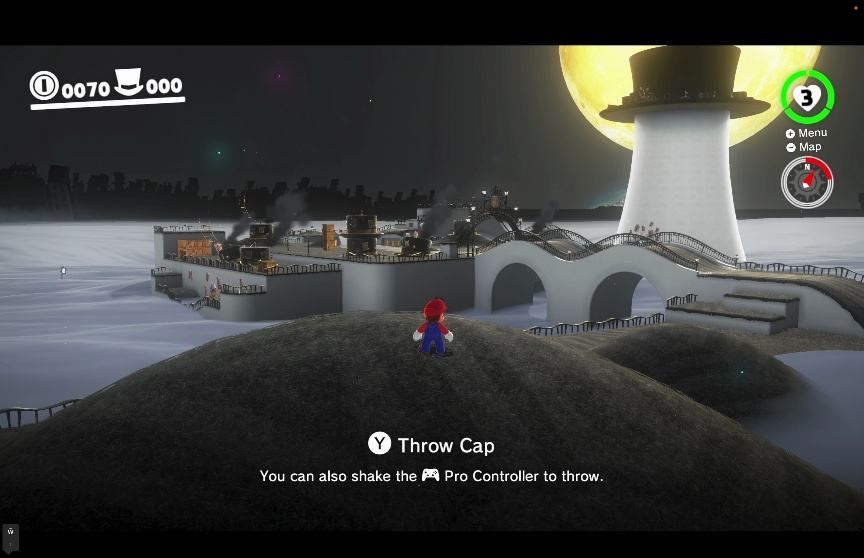

In [48]:
## Display the frames and audio for context
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(0.025)

## Inference

In [50]:
response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content": "You are generating a video summary. Please provide a summary of the video. Respond in Markdown."},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames)
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

### Video Summary

The video appears to be gameplay footage from the video game "Super Mario Odyssey." The frames show Mario in a dark, eerie environment with a large moon in the background. Mario is seen climbing a hill and reaching the top, where he overlooks a town with buildings and bridges. The game interface indicates that the player can throw Mario's cap by pressing the "Y" button or shaking the Pro Controller. The health meter shows that Mario has three health points, and the coin counter indicates that he has collected 70 coins. The environment is characterized by a monochromatic color scheme, with a large hat-shaped structure visible in the distance. The frames suggest that Mario is exploring the area, possibly looking for objectives or items.


In [17]:
import os

def load_video_and_extract_frames(video_path, output_dir, seconds_per_frame=4):
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    curr_frame = 0
    
    os.makedirs(output_dir, exist_ok=True)
    
    while curr_frame < total_frames:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        
        frame_path = os.path.join(output_dir, f"frame_{curr_frame:06d}.jpg")
        cv2.imwrite(frame_path, frame)
        
        curr_frame += frames_to_skip
    
    video.release()
    print(f"Extracted and saved {curr_frame // frames_to_skip} frames from {video_path} to {output_dir}")

load_video_and_extract_frames("/Users/sarathmenon/Desktop/mario_vid.mov", "/Users/sarathmenon/Documents/master_thesis/waste")


Extracted and saved 5 frames from /Users/sarathmenon/Desktop/mario_vid.mov to /Users/sarathmenon/Documents/master_thesis/waste
